In [33]:
# Dataframe
import pandas as pd

# Numeric calculation
import numpy as np
import statistics as st
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import f_classif

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import chi2_contingency
import openpyxl
import category_encoders as ce

from imblearn.over_sampling import  SMOTE
from imblearn.under_sampling import  NearMiss

from sklearn.metrics import classification_report, roc_auc_score, recall_score

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [132]:
train = pd.read_csv('Train.csv')
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [207]:
test = pd.read_csv('Test.csv')
test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


## 1. Exploratory Data Analysis

1.1 Knowing About Data (Statistik Deskriptif)

In [9]:
d1=train.isnull().sum().to_frame().rename(columns={0: "Train_Null_Values"})
d2=test.isnull().sum().to_frame().rename(columns={0: "Test_Null_Values"})
d3=train.dtypes.to_frame().rename(columns={0: "Data_Type"})
pd.concat([d1, d2,d3], axis=1)

,Train_Null_Values,Test_Null_Values,Data_Type
Loan_ID,0,0.0,int64
Loan_Amount_Requested,0,0.0,object
Length_Employed,7371,4936.0,object
Home_Owner,25349,16711.0,object
Annual_Income,25102,16898.0,float64
Income_Verified,0,0.0,object
Purpose_Of_Loan,0,0.0,object
Debt_To_Income,0,0.0,float64
Inquiries_Last_6Mo,0,0.0,int64
Months_Since_Deliquency,88379,58859.0,float64


In [10]:
train.shape, test.shape

((164309, 14), (109541, 13))

In [45]:
df = train.append(test, ignore_index=True)
df.shape

(273850, 14)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273850 entries, 0 to 109540
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  273850 non-null  int64  
 1   Loan_Amount_Requested    273850 non-null  object 
 2   Length_Employed          261543 non-null  object 
 3   Home_Owner               231790 non-null  object 
 4   Annual_Income            231850 non-null  float64
 5   Income_Verified          273850 non-null  object 
 6   Purpose_Of_Loan          273850 non-null  object 
 7   Debt_To_Income           273850 non-null  float64
 8   Inquiries_Last_6Mo       273850 non-null  int64  
 9   Months_Since_Deliquency  126612 non-null  float64
 10  Number_Open_Accounts     273850 non-null  int64  
 11  Total_Accounts           273850 non-null  int64  
 12  Gender                   273850 non-null  object 
 13  Interest_Rate            164309 non-null  float64
dtypes: f

In [40]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Loan_ID,273850.0,1.013693e+07,79053.829946,10000001.0,10068463.25,10136925.50,10205387.75,10273850.00
Annual_Income,231850.0,7.339279e+04,58529.835485,3000.0,45000.00,63000.00,89000.00,7500000.00
Debt_To_Income,273850.0,1.721590e+01,7.845967,0.0,11.36,16.85,22.78,39.99
Inquiries_Last_6Mo,273850.0,7.845426e-01,1.036816,0.0,0.00,0.00,1.00,8.00
Months_Since_Deliquency,126612.0,3.410339e+01,21.750307,0.0,16.00,31.00,49.00,180.00
Number_Open_Accounts,273850.0,1.118603e+01,4.973663,0.0,8.00,10.00,14.00,84.00
Total_Accounts,273850.0,2.506798e+01,11.589677,2.0,17.00,23.00,32.00,156.00
Interest_Rate,164309.0,2.158951e+00,0.738364,1.0,2.00,2.00,3.00,3.00


In [41]:
df.describe(include=object).transpose()

,count,unique,top,freq
Loan_Amount_Requested,273850,1320,"10,000",19442
Length_Employed,261543,11,10+ years,88328
Home_Owner,231790,5,Mortgage,117270
Income_Verified,273850,3,VERIFIED - income,99076
Purpose_Of_Loan,273850,14,debt_consolidation,161403
Gender,273850,2,Male,194993


In [42]:
df.isnull().sum()/len(df)

Loan_ID                    0.000000
Loan_Amount_Requested      0.000000
Length_Employed            0.044941
Home_Owner                 0.153588
Annual_Income              0.153369
Income_Verified            0.000000
Purpose_Of_Loan            0.000000
Debt_To_Income             0.000000
Inquiries_Last_6Mo         0.000000
Months_Since_Deliquency    0.537659
Number_Open_Accounts       0.000000
Total_Accounts             0.000000
Gender                     0.000000
Interest_Rate              0.400004
dtype: float64

In [18]:
def analyze(column):
  data = {}
  data['Column'] = column.name
  data['Mean'] = st.mean(column)
  data['Mode'] = Counter(column).most_common()[0][0]
  data['Median'] = st.median(column)
  data['Variance'] = st.variance(column)
  data['Standard Deviation'] = st.stdev(column)
  data['Skew'] = column.skew()
  return pd.DataFrame([data])

def dataframe_analysis():
  result = pd.DataFrame()

  for col in df_num.columns:
    analysis = analyze(df[col])
    result = result.append(analysis)

  return result.reset_index(drop=True)

def plot_distribution(column):
  f, (ax_box, ax_hist) = plt.subplots(nrows=2, 
                                      sharex=True, 
                                      figsize=(8, 5),
                                      gridspec_kw={"height_ratios": {0.2, 1}})
  
  info = analyze(column)
  mean = info['Mean'].values[0]
  median = info['Median'].values[0]
  mode = info['Mode'].values[0]

  sns.boxplot(x=column, ax=ax_box)
  ax_box.axvline(mean, color='r', linestyle='--')
  ax_box.axvline(median, color='g', linestyle=':')
  ax_box.axvline(mode, color='b', linestyle='-')
  ax_box.set(xlabel='')

  sns.histplot(x=column, ax=ax_hist, kde=True)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle=':')
  ax_hist.axvline(mode, color='b', linestyle='-')

  plt.legend({'Mean':mean, 'Median':median, 'Mode':mode})
  plt.show()

In [50]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics)
df_num.drop(['Interest_Rate', 'Loan_ID'], axis=1, inplace=True)
df_num.head()

,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts
0,68000.0,18.37,0,NaN,9,14
1,NaN,14.93,0,17.0,12,24
2,75566.4,15.88,0,NaN,12,16
3,56160.0,14.34,3,NaN,16,22
4,96000.0,22.17,1,NaN,19,30


In [23]:
dataframe_analysis()

,Column,Mean,Mode,Median,Variance,Standard Deviation,Skew
0,Loan_ID,1.013693e+07,10000001.0,10136925.50,6.249508e+09,79053.829946,-3.481617e-16
1,Annual_Income,NaN,60000.0,74000.00,NaN,NaN,3.686797e+01
2,Debt_To_Income,1.721590e+01,14.4,16.85,6.155919e+01,7.845967,1.921321e-01
3,Inquiries_Last_6Mo,7.845426e-01,0.0,0.00,1.074988e+00,1.036816,1.545926e+00
4,Months_Since_Deliquency,NaN,9.0,NaN,NaN,NaN,4.661013e-01
5,Number_Open_Accounts,1.118603e+01,9.0,10.00,2.473733e+01,4.973663,1.161028e+00
6,Total_Accounts,2.506798e+01,21.0,23.00,1.343206e+02,11.589677,8.197533e-01


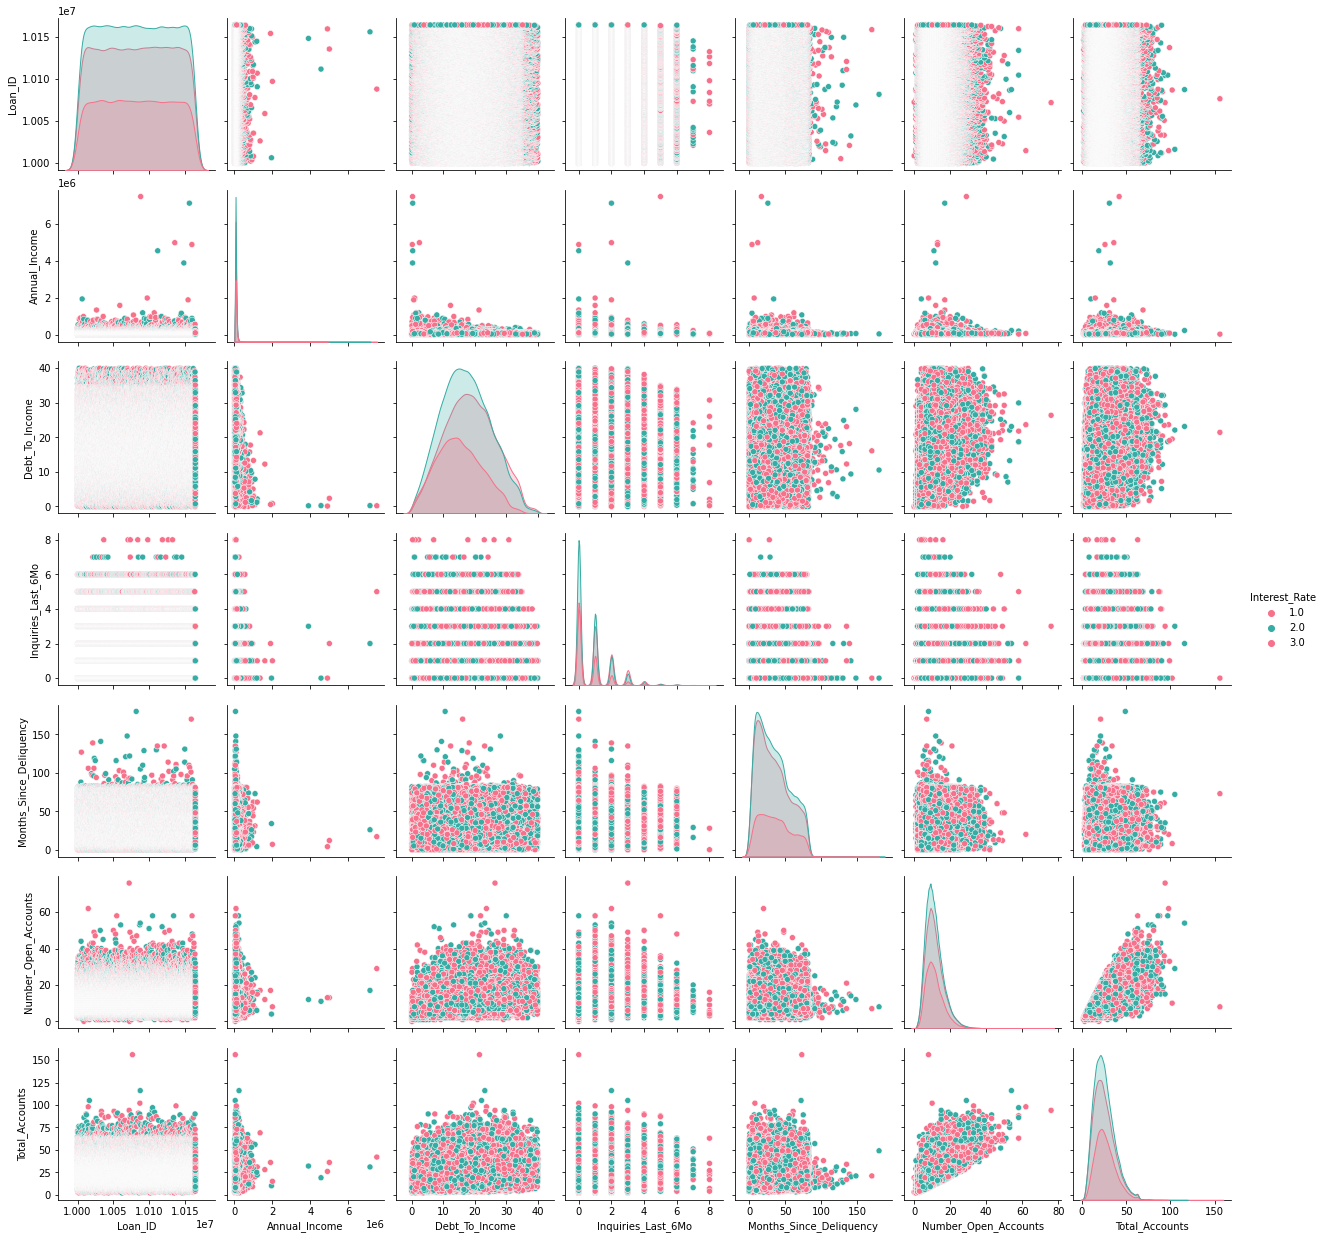

In [48]:
sns.pairplot(df, hue="Interest_Rate", palette="husl")

Plot Disctribution Column :  Annual_Income


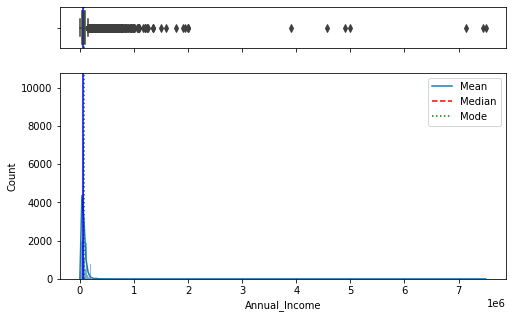

Plot Disctribution Column :  Debt_To_Income


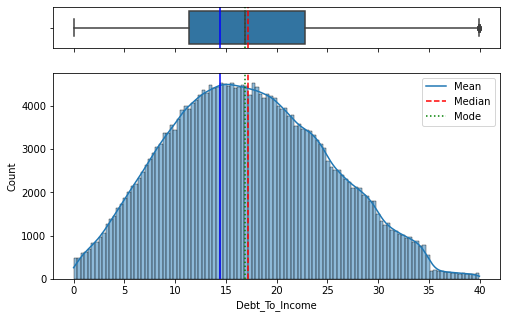

Plot Disctribution Column :  Inquiries_Last_6Mo


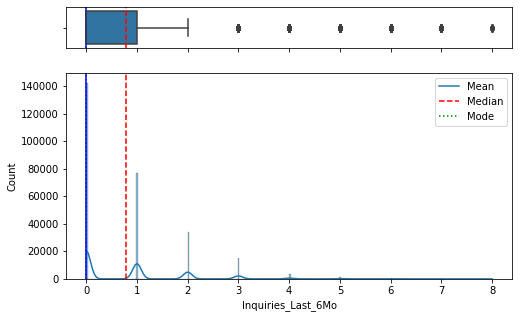

Plot Disctribution Column :  Months_Since_Deliquency


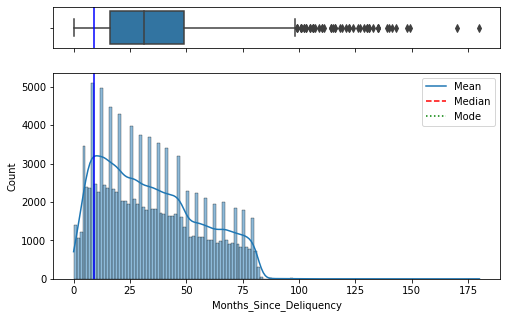

Plot Disctribution Column :  Number_Open_Accounts


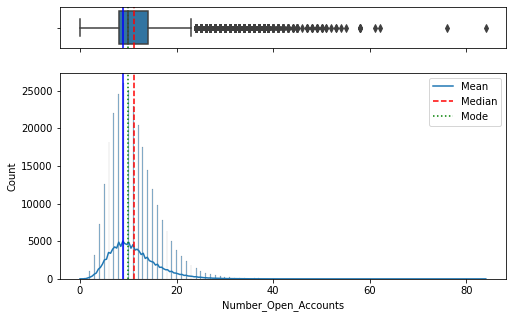

Plot Disctribution Column :  Total_Accounts


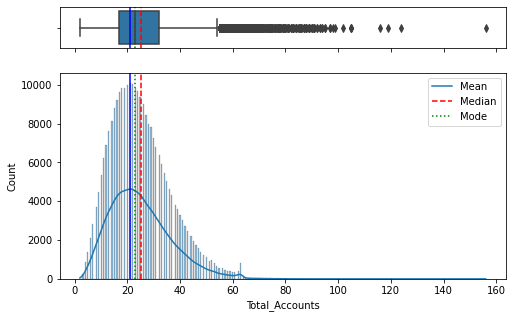

In [51]:
for col in df_num.columns:
    print("Plot Disctribution Column : ", col)
    plot_distribution(df_num[col])
    print("=======================")

In [54]:
cont_col = ['Loan_Amount_Requested','Annual_Income','Debt_To_Income','Months_Since_Deliquency','Number_Open_Accounts',
 'Total_Accounts']
ord_col = ['Length_Employed', 'Inquiries_Last_6Mo']
nom_col = ['Home_Owner','Income_Verified','Purpose_Of_Loan','Gender']

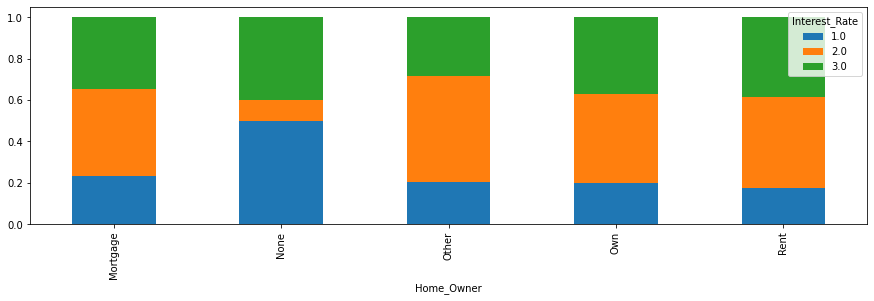

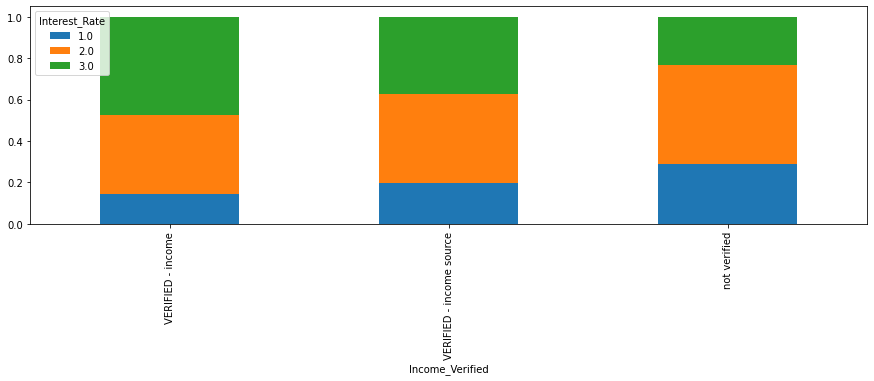

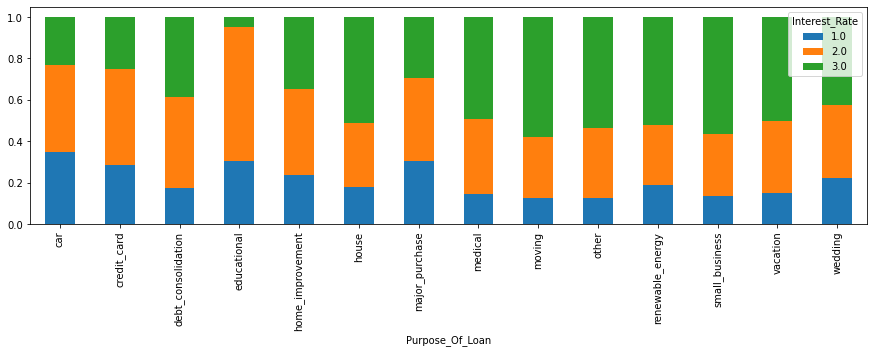

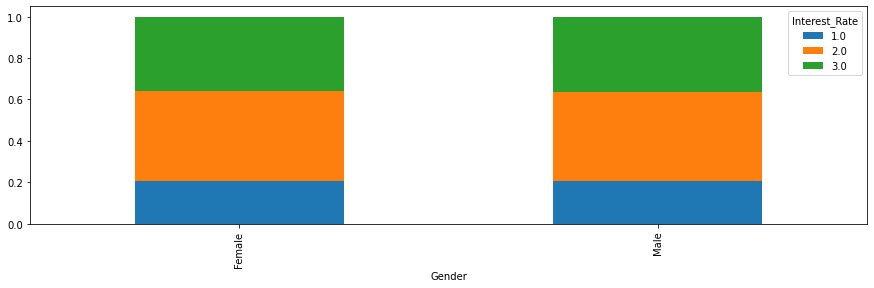

In [55]:
for col in nom_col:
    Gender=pd.crosstab(df[col],df['Interest_Rate']) 
    #print(Gender)
    Gender.div(Gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(15,4))

### 1.3 Target Exploration

In [31]:
df['Interest_Rate'].value_counts(normalize=True)

2.0    0.429557
3.0    0.364697
1.0    0.205746
Name: Interest_Rate, dtype: float64

<AxesSubplot:>

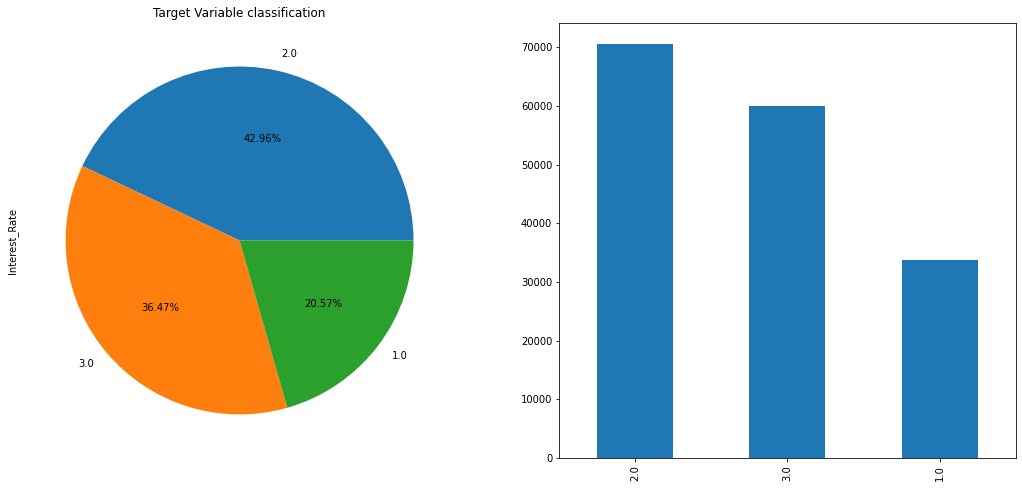

In [53]:
#f,ax = plt.subplots(1,2,figsize = (18,8))
plt.subplot(121)
df['Interest_Rate'].value_counts().plot.pie(autopct = '%1.2f%%',figsize = (18,8),title = 'Target Variable classification')
plt.subplot(122)
df['Interest_Rate'].value_counts().plot.bar(figsize = (18,8))

### Hasil temuan dari EDA :

1. Categorical variables are
    * Nominal: ```'Home_Owner','Income_Verified','Purpose_Of_Loan','Gender'```
    * Ordinal: ```'Length_Employed', Inquiries_Last_6Mo```
2. Continous variables are ```Loan_Amount_Requested, Annual_Income, Debt_To_Income, Months_Since_Deliquency, Number_Open_Accounts,Total_Accounts```
3. There are outliers and we try to handling it on preprocessing step
4. Fitur ```Loan_ID``` adalah identifier. Kita akan drop fitur ini 


## 2. Preprocessing

### 2.1 Drop 'Loan_ID' dan Koreksi Tipe Data

In [133]:
train.drop(columns=['Loan_ID'], axis = 1, inplace=True)
test.drop(columns=['Loan_ID'], axis = 1, inplace=True)

In [72]:
df.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1.0
1,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3.0
2,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3.0
3,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3.0
4,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1.0


In [134]:
train.Loan_Amount_Requested=train.Loan_Amount_Requested.apply(lambda x: x.replace(',',''))
train.Loan_Amount_Requested=train.Loan_Amount_Requested.astype(int)

In [136]:
test.Loan_Amount_Requested=test.Loan_Amount_Requested.apply(lambda x: x.replace(',',''))
test.Loan_Amount_Requested=test.Loan_Amount_Requested.astype(int)

In [122]:
train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,9,14,Female,1
1,30000,4 years,Mortgage,63000.0,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,3
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,3
3,16000,< 1 year,Mortgage,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male,3
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female,1


### 2.2 Handling Missing Value

In [84]:
train.isnull().sum()

Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

In [137]:
train.drop('Months_Since_Deliquency',axis = 1,inplace = True)
test.drop('Months_Since_Deliquency',axis = 1,inplace = True)

In [86]:
train['Length_Employed'].value_counts()

10+ years    52915
2 years      14620
3 years      12974
< 1 year     12805
5 years      10814
1 year       10422
4 years       9784
7 years       9308
6 years       9094
8 years       7917
9 years       6285
Name: Length_Employed, dtype: int64

In [87]:
train['Home_Owner'].value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [138]:
train['Length_Employed'].fillna(train['Length_Employed'].mode()[0],inplace = True)
train['Home_Owner'].fillna(train['Home_Owner'].mode()[0],inplace = True)

In [139]:
test['Length_Employed'].fillna(train['Length_Employed'].mode()[0],inplace = True)
test['Home_Owner'].fillna(train['Home_Owner'].mode()[0],inplace = True)

In [140]:
train['Annual_Income'].fillna(train['Annual_Income'].median(),inplace = True)
test['Annual_Income'].fillna(train['Annual_Income'].median(),inplace = True)

In [141]:
train.isnull().sum()

Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
dtype: int64

### 2.3 Data Splitting

In [142]:
# inisialiasi X dan y
X = train.drop(columns=['Interest_Rate'], axis = 1)
y = train['Interest_Rate']

In [143]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y, 
    stratify = y,
    test_size = 0.8, 
    random_state = 2022)

### 2.4 Feature Selection

In [95]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [129]:
X_train_cat.columns

Index(['Loan_Amount_Requested', 'Length_Employed', 'Home_Owner',
       'Income_Verified', 'Purpose_Of_Loan', 'Gender'],
      dtype='object')

In [130]:
X_train_num.columns

Index(['Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo',
       'Number_Open_Accounts', 'Total_Accounts'],
      dtype='object')

#### 2.4.1 Chi-square

Chi-Squared Test ini digunakan untuk menguji hipotesis apakah dua variabel kategorikal independen atau saling berkaitan. Misalnya, kita akan menguji salah satu fitur bertipe kategorik pada data kita yaitu ```pendidikan```. Apakah pendidikan seseorang memiliki keterkaitan (dependensi) dengan apakah dia dipromosikan atau tidak (fitur independen kita adalah ```dipromosikan```)?
Hipotesis yang bisa kita ajukan yaitu
* Ho: Kedua variabel independen, artinya variabel ```pendidikan``` tidak berkaitan atau independen terhadap variabel ```dipromosikan```.
* Ha: Kedua variabel dependen, artinya variabel ```pendidikan``` berkaitan atau dependen terhadap variabel ```dipromosikan```.

Ho ditolak ketika P-Value kurang dari sama dengan alpha (α). Nilai alpha yang kita pakai sebesar 0.05.

In [99]:
chi2_check = {}

for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [100]:
# convert dari dictionary ke DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,Loan_Amount_Requested,0.000000e+00
1,Home_Owner,0.000000e+00
2,Income_Verified,0.000000e+00
3,Purpose_Of_Loan,0.000000e+00
4,Length_Employed,1.433000e-07
5,Gender,1.363695e-01


Kita simpan semua fitur diatas karena mempunyai ```p-value``` < 0.05

#### 2.4.2 F-Statistic

Uji F (F-Statistic) digunakan untuk menguji apakah variabel independen mempengaruhi variabel dependen secara signifikan. Uji F memerlukan asumsi bahwa error menyebar normal. Jika error tidak menyebar normal hasil pengujian tidak akan valid. Hipotesis Null dari uji ini adalah variabel independen tidak berpengaruh signifikan terhadap variabel dependen sedangkan Hipotesis alternatifnya adalah variabel independen berpengaruh signifikan terhadap variabel dependen. Test statistik yang digunakan dalam uji ini adalah F statististics kriteria penolakan Hipotesis Null adalah p-value < alpha. Variabel yang akan kita gunakan untuk uji F ini adalah fitur yang bertipe numerik

In [101]:
F_statistic, p_values = f_classif(X_train_num, y_train)

In [102]:
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=3)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

In [103]:
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,Inquiries_Last_6Mo,591.167781,0.0
1,Debt_To_Income,372.556908,0.0
2,Annual_Income,121.668023,0.0
3,Total_Accounts,48.928309,0.0
4,Number_Open_Accounts,12.489321,0.0


Statistik F ANOVA untuk 6 fitur numerik menunjukkan rentang nilai F yang luas. Kita akan simpan semua fitur ini untuk tetap digunakan dalam permodelan karena mempunyai p-value < 0.05

#### 2.4.3 Multicollinearity

Adanya korelasi yang tinggi antara variabel independen dinamakan multikolinearitas. Korelasi antara variabel indepen tentu saja ada, hanya masalah seberapa besar nilai korelasinya. Ketika melakukan analisis regresi, kita berasumsi bahwa tidak ada korelasi yang sempurna antar variabel independen saat metode least square digunakan untuk estimasi parameter regresi. Ketika terdapat multikolinieritas, interpretasi slope dalam multiple linear regresi menjadi tidak berlaku karena dependen variabel bukan satu-satunya variabel yang nilainya berubah. Pada klasifikasi, adanya multicollinearity akan mengakibatkan performa model yang bias dan menjadi salah arah.

Pada tugas ini saya menggunakan heatmap correlation dan nilai VIF. VIF adalah sebuah ukuran relatif yang mengukur dampak multikolinearitas terhadap perubahan dari ragam nilai koefisien regresi. Nilai VIF yang lebih besar dari 10 mengindikasikan adanya masalah multikolinieritas yang serius.




<AxesSubplot:>

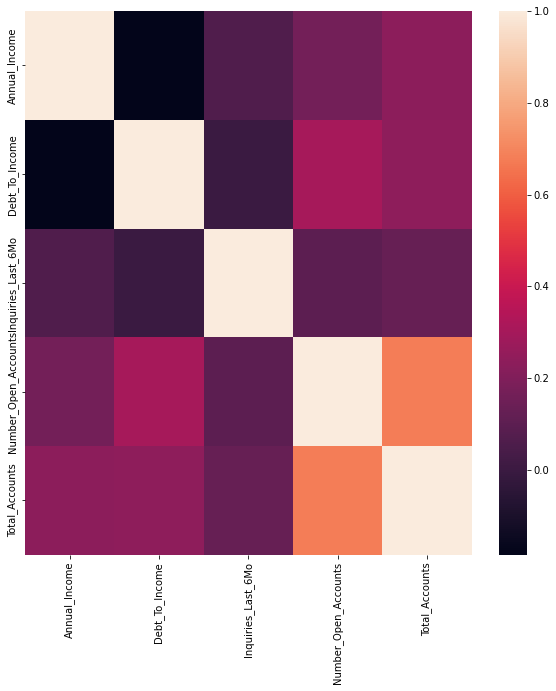

In [104]:
corrmat = X_train_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

Setelah melakukan pairwise correlation kita menemukan bahwa fitur ```Number_Open_Accounts``` dan ```Total_Accounts``` terkorelasi tinggi dimana masuk akal. Kreditur yang mempunyai pinjaman aktif cenderung sudah pernah melakukan kredit sebelumnya.  Oleh karena itu kita sebaiknya drop fitur ini. Namun kita coba mempertahankan dulu fitur ini dan melakukan uji VIF. Jika model yang dihasilkan kurang representatif, kita akan lakukan pemodelan dengan drop fitur ini

In [105]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [106]:
calc_vif(X_train_num).sort_values('VIF')

,variables,VIF
2,Inquiries_Last_6Mo,1.570957
0,Annual_Income,3.224161
1,Debt_To_Income,4.734014
4,Total_Accounts,10.766207
3,Number_Open_Accounts,11.209871


Variance Inflation Factor (VIF) adalah ukuran relatif dari peningkatan varians dalam standard error karena kolinearitas.
Nilai VIF yang lebih besar dari 10 menunjukkan bahwa kolinearitas sangat tinggi. Karena menggunakan pairwise correlation fitur ```Number_Open_Accounts``` sudah terindikasi multicollinarity dan VIF juga menunjukkan hal yang sama, maka kita drop fitur ini

In [144]:
X_train.drop(columns=['Number_Open_Accounts'], axis = 1, inplace=True)
test.drop(columns=['Number_Open_Accounts'], axis = 1, inplace=True)
X_val.drop(columns=['Number_Open_Accounts'], axis = 1, inplace=True)

In [151]:
X_train.head()

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Total_Accounts,Gender
3735,10000,4 years,Mortgage,35778.0,VERIFIED - income,debt_consolidation,18.92,0,34,Male
60186,20000,10+ years,Mortgage,65000.0,VERIFIED - income,credit_card,26.97,2,63,Male
51597,25000,4 years,Mortgage,66000.0,VERIFIED - income,debt_consolidation,18.80,2,31,Male
3548,12000,3 years,Rent,190000.0,VERIFIED - income source,other,8.17,0,23,Male
98538,5400,2 years,Mortgage,18600.0,not verified,debt_consolidation,7.03,0,5,Male


### 2.5 Feature Engineering

Pada feature engineering, metode yang saya pakai adalah encoding dan scaling. Encoding adalah suatu metode yang dapat diterapkan untuk merepresentasikan variabel kategorik dalam machine learning. Ada berbagai macam jenis metode encoding di antaranya one hot encoding, ordinal encoding dan binary encoding.

Kita dapat memilih metode encoding berdasarkan skala pengukuran datanya, yaitu nominal atau ordinal. Seperti yang sudah kita ketahui, variabel nominal adalah variabel kategorik yang tidak memiliki urutan contohnya seperti gender, pekerjaan dan wilayah. Sedangkan variabel ordinal adalah variabel kategorik yang memiliki makna tertentu ketika diurutkan misalnya tingkat pendidikan. 

Scaling adalah metode untuk melakukan transformasi terhadap data numerik agar antar variabel memiliki skala yang sama. Metode scaling yang dapat digunakan ada berbagai macam. Yang akan saya bahas adalah MinMax Scaler, Standard Scaler, dan Robust Scaler. Ketiganya merupakan metode untuk mentransformasi data sehingga data memiliki skala yang kecil. Beberapa algoritma machine learning dapat memiliki performa yang lebih baik ketika skala yang digunakan sama. Contohnya adalah metode KNN, Neural Network, dan Linear Regression. Pada dataset ini saya mencoba menggunakan Robust Scaler. Robust scaler ini dapat dijadikan sebagai alternatif karena min max scaler sangat sensitif terhadap outlier. Data dikurangi dengan nilai kuartil 1 lalu dibagi dengan selisih antara kuartil 3 dan kuartil 1.

Skenario untuk dataset ini adalah :

1. Fitur ```'Length_Employed'``` -> ordinal encoding
2. Fitur ```'Home_Owner','Income_Verified','Purpose_Of_Loan', 'Gender'``` -> OneHotEncoder
3. Fitur ```'Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Total_Accounts'``` -> Robust Scaler


In [163]:
(train == 'None').sum()

Loan_Amount_Requested     0
Length_Employed           0
Home_Owner               10
Annual_Income             0
Income_Verified           0
Purpose_Of_Loan           0
Debt_To_Income            0
Inquiries_Last_6Mo        0
Number_Open_Accounts      0
Total_Accounts            0
Gender                    0
Interest_Rate             0
dtype: int64

In [110]:
enc = ['Loan_Amount_Requested', 'Annual_Income', 'Debt_To_Income', 'Inquiries_Last_6Mo', 'Total_Accounts']

In [115]:
ordinal_mapping = [
    {'col':'Length_Employed',
    'mapping':{'< 1 year':1,'2 years':2,'3 years':3,'4 years':4, '5 years':5, '6 years': 6, '7 years': 7, '8 years':8, '9 yaers': 9, '10+ years':10}}
    ]

ordinal_encoder = ce.OrdinalEncoder(cols = 'Length_Employed',mapping = ordinal_mapping)

In [165]:
transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(handle_unknown = 'ignore'),['Home_Owner','Income_Verified','Purpose_Of_Loan', 'Gender']),
                                 ('binary encoder',ordinal_encoder,['Length_Employed']),
                                 ('robust scaler',RobustScaler(),enc)
                                ], remainder = 'passthrough')

In [150]:
test.isnull().sum()

Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Total_Accounts           0
Gender                   0
dtype: int64

In [166]:
X_train_preprocessed = transformer.fit_transform(X_train)
X_val_preprocessed = transformer.transform(X_val)
test_preprocessed = transformer.transform(test)

In [170]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
X_test_preprocessed = pd.DataFrame(X_val_preprocessed)
test_preprocessed = pd.DataFrame(test_preprocessed)
X_train_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,-0.166667,-0.817477,0.181581,0.0,0.733333
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.666667,0.060060,0.880973,2.0,2.666667
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.083333,0.090090,0.171156,2.0,0.533333
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.000000,3.813814,-0.752389,0.0,0.000000
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-0.550000,-1.333333,-0.851434,0.0,-1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32856,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.000000,0.060060,-0.448306,0.0,-0.933333
32857,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,-0.306250,-1.141141,0.080799,0.0,0.066667
32858,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,-0.708333,-0.267748,-0.766290,2.0,1.533333
32859,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.000000,-0.810811,0.292789,0.0,0.533333


In [171]:
transformer.transformers_

[('one hot encoder',
  OneHotEncoder(handle_unknown='ignore'),
  ['Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']),
 ('binary encoder',
  OrdinalEncoder(cols=['Length_Employed'],
                 mapping=[{'col': 'Length_Employed',
                           'mapping': {'10+ years': 10, '2 years': 2,
                                       '3 years': 3, '4 years': 4, '5 years': 5,
                                       '6 years': 6, '7 years': 7, '8 years': 8,
                                       '9 yaers': 9, '< 1 year': 1}}]),
  ['Length_Employed']),
 ('robust scaler',
  RobustScaler(),
  ['Loan_Amount_Requested',
   'Annual_Income',
   'Debt_To_Income',
   'Inquiries_Last_6Mo',
   'Total_Accounts'])]

In [172]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_Mortgage', 'x0_Other', 'x0_Own', 'x0_Rent',
       'x1_VERIFIED - income', 'x1_VERIFIED - income source',
       'x1_not verified', 'x2_car', 'x2_credit_card',
       'x2_debt_consolidation', 'x2_educational', 'x2_home_improvement',
       'x2_house', 'x2_major_purchase', 'x2_medical', 'x2_moving',
       'x2_other', 'x2_renewable_energy', 'x2_small_business',
       'x2_vacation', 'x2_wedding', 'x3_Female', 'x3_Male'], dtype=object)

In [173]:
transformer.transformers_[1][1].get_feature_names()

['Length_Employed']

In [177]:
features = list(['x0_Mortgage', 'x0_Other', 'x0_Own', 'x0_Rent',
       'x1_VERIFIED - income', 'x1_VERIFIED - income source',
       'x1_not verified', 'x2_car', 'x2_credit_card',
       'x2_debt_consolidation', 'x2_educational', 'x2_home_improvement',
       'x2_house', 'x2_major_purchase', 'x2_medical', 'x2_moving',
       'x2_other', 'x2_renewable_energy', 'x2_small_business',
       'x2_vacation', 'x2_wedding', 'x3_Female', 'x3_Male', 'Length_Employed', 'Loan_Amount_Requested',
   'Annual_Income',
   'Debt_To_Income',
   'Inquiries_Last_6Mo',
   'Total_Accounts'])

In [181]:
X_train_preprocessed.columns = features
X_test_preprocessed.columns = features
test_preprocessed.columns = features
X_train_preprocessed

,x0_Mortgage,x0_Other,x0_Own,x0_Rent,x1_VERIFIED - income,x1_VERIFIED - income source,x1_not verified,x2_car,x2_credit_card,x2_debt_consolidation,x2_educational,x2_home_improvement,x2_house,x2_major_purchase,x2_medical,x2_moving,x2_other,x2_renewable_energy,x2_small_business,x2_vacation,x2_wedding,x3_Female,x3_Male,Length_Employed,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Total_Accounts
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,-0.166667,-0.817477,0.181581,0.0,0.733333
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,0.666667,0.060060,0.880973,2.0,2.666667
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.083333,0.090090,0.171156,2.0,0.533333
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.000000,3.813814,-0.752389,0.0,0.000000
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-0.550000,-1.333333,-0.851434,0.0,-1.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32856,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.000000,0.060060,-0.448306,0.0,-0.933333
32857,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,-0.306250,-1.141141,0.080799,0.0,0.066667
32858,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,-0.708333,-0.267748,-0.766290,2.0,1.533333
32859,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.000000,-0.810811,0.292789,0.0,0.533333


### 3. Modeling

--------------------

### 3.1 Baseline Model Performance

Sebagai baseline, kita memakai 6 model berbasis single dan ensemble learning (kalian bisa klik untuk detail masing-masing classifier):
1. [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)  
2. [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
3. [AdaBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#:~:text=An%20AdaBoost%20%5B1%5D%20classifier%20is,focus%20more%20on%20difficult%20cases.)
4. [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
5. [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
6. [CatBoostClassifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier)

Dari sini kita menggunakan hanya ```X_train_preprocessed``` dan ```X_test_preprocessed``` untuk memilih model dan skenario terbaik. ```test``` hanya digunakan untuk melihat performansi akhir untuk menghindari data leakage

In [182]:
from catboost import CatBoostClassifier

In [190]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth = 5)
knn = KNeighborsClassifier(n_neighbors = 3)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=100)
rf = RandomForestClassifier(n_estimators = 50, max_features = 4, max_depth = 3)
cb = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='MultiClass',
                           verbose=True)

In [187]:
import sklearn.metrics as metrics

In [191]:
plt.figure(figsize= (10,10)).clf()

for clfs, clf_name in zip([dt,rf,ada, lr, knn, cb],['Decision Tree','Random Forest','AdaBoost', 'LogisticRegression', 'KNeighborsClassifier', 'CatBoostClassifier']):
  clfs.fit(X_train_preprocessed, y_train)
  y_pred = clfs.predict(X_test_preprocessed)
  accuracy = metrics.accuracy_score(y_val,y_pred)
  print(clf_name+":")
  print('Accuracy : ', accuracy)

Decision Tree:
Accuracy :  0.4919816201083318
Random Forest:
Accuracy :  0.48850496013632766
AdaBoost:
Accuracy :  0.47477329438256954
LogisticRegression:
Accuracy :  0.5148651938409105
KNeighborsClassifier:
Accuracy :  0.4155179234374049


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.0233261	total: 229ms	remaining: 229ms
1:	learn: 1.0079658	total: 240ms	remaining: 0us
CatBoostClassifier:
Accuracy :  0.49017101819730996


<Figure size 720x720 with 0 Axes>

### 3.2 Apakah dengan Voting Classifier lebih baik?

Dalam voting classifier, seperti namanya kita terapkan sistem voting untuk memperoleh sistem voting. Pada awalnya kita persiapkan terlebih dahulu model-model apa saja yang akan digunakan misalkan kita gunakan Logistic regression, Decision Tree, KNN, Random Forest, CatBoost, dan Adaboost. Sebagai prediksi akhir kita gabungkan hasil prediksi dari masing-masing model dengan sistem voting. 

Secara teoritis kita dapat gunakan lebih banyak model lagi tetapi jika model yang digabungkan terlalu banyak justru akan terlalu makan banyak waktu untuk training dan prediksi. Hal ini justru akan membuat metode ensemble yang telah dibangun menjadi semakin tidak praktikal. Terkait sistem votingnya, sistem voting yang dapat digunakan terbagi menjadi dua jenis, yaitu soft voting dan hard voting. Yang saya gunakan pada notebook ini adalah soft voting. Pada soft voting kita tidak langsung menggabungkan kelas dalam soft voting tetapi yang kita gabungkan terlebih dahulu adalah score atau probabilitasnya. Untuk setiap data poin atau baris, kita hitung rata-rata dari skor kemudian kita peroleh kelasnya dari rata-rata score. 




In [192]:
vc = VotingClassifier([('clf1',lr),('clf2',dt),('clf3',knn), ('clf4',ada),('clf5',rf),('clf6',cb)], voting = 'soft')

In [193]:
vc.fit(X_train_preprocessed, y_train)

0:	learn: 1.0233261	total: 25.8ms	remaining: 25.8ms
1:	learn: 1.0079658	total: 36.7ms	remaining: 0us


VotingClassifier(estimators=[('clf1', LogisticRegression()),
                             ('clf2', DecisionTreeClassifier(max_depth=5)),
                             ('clf3', KNeighborsClassifier(n_neighbors=3)),
                             ('clf4',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                                 n_estimators=100)),
                             ('clf5',
                              RandomForestClassifier(max_depth=3,
                                                     max_features=4,
                                                     n_estimators=50)),
                             ('clf6',
                              <catboost.core.CatBoostClassifier object at 0x000001BF0D2358B0>)],
                 voting='soft')

In [194]:
y_pred = vc.predict(X_val_preprocessed)

In [195]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           1       0.48      0.09      0.14     27045
           2       0.48      0.67      0.56     56464
           3       0.54      0.53      0.54     47939

    accuracy                           0.50    131448
   macro avg       0.50      0.43      0.41    131448
weighted avg       0.50      0.50      0.46    131448



In [196]:
metrics.accuracy_score(y_val,y_pred)

0.4994979003103889

### 3.3 Tuning Logistic Regression

In [197]:
from sklearn.model_selection import RandomizedSearchCV

In [198]:
#List Hyperparameters yang akan diuji
penalty = ['l1', 'l2']
C = np.logspace(-4,4,20)

#Menjadikan ke dalam bentuk dictionary
hyperparameters = dict(penalty=penalty, C=C)

#Membuat Object Logistic Regression
logreg = LogisticRegression()

#Memasukan ke Randomized Search
#CV itu Cross Validation
#Menggunakan 10-Fold CV
clf = RandomizedSearchCV(logreg, hyperparameters, cv=10)

#Fitting Model
best_model = clf.fit(X_train_preprocessed,y_train)

#Nilai hyperparameters terbaik
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

#Prediksi menggunakan model baru
y_pred = best_model.predict(X_val_preprocessed)

#Check performa dari model
print(classification_report(y_val, y_pred))

Best Penalty: l2
Best C: 1438.44988828766
              precision    recall  f1-score   support

           1       0.50      0.13      0.21     27045
           2       0.49      0.67      0.56     56464
           3       0.56      0.55      0.56     47939

    accuracy                           0.51    131448
   macro avg       0.52      0.45      0.44    131448
weighted avg       0.52      0.51      0.49    131448



In [200]:
clf.best_estimator_

LogisticRegression(C=1438.44988828766)

## 4. Testing

In [201]:
clf.best_estimator_.fit(X_train_preprocessed,y_train)

LogisticRegression(C=1438.44988828766)

In [203]:
y_pred = clf.best_estimator_.predict(test_preprocessed)

In [204]:
y_pred

array([2, 1, 2, ..., 2, 3, 2], dtype=int64)

In [208]:
submission = pd.DataFrame()
submission['Loan_ID'] = test['Loan_ID']
submission['Interest_Rate'] = y_pred.astype('int')
submission.head()

,Loan_ID,Interest_Rate
0,10164310,2
1,10164311,1
2,10164312,2
3,10164313,2
4,10164314,2


In [209]:
submission.to_csv('submission.csv', index=False)
submission['Interest_Rate'].value_counts()

2    64847
3    38861
1     5833
Name: Interest_Rate, dtype: int64